<p style='text-align: center;'><span style="color: #000508; font-family: Segoe UI; font-size: 2.6em; font-weight: 300;">SUPERVISED CONTRASTIVE LEARNING</span></p>

![](https://paperswithcode.com/media/methods/Screen_Shot_2020-06-12_at_12.43.14_PM.png)

Contrastive learning applied to self-supervised representation learning has seen a resurgence in recent years, leading to state of the art performance in the unsupervised training of deep image models. Modern batch contrastive approaches subsume or significantly outperform traditional contrastive losses such as triplet, max-margin and the N-pairs loss. In this work, we extend the self-supervised batch contrastive approach to the fully-supervised setting, allowing us to effectively leverage label information. <strong>Clusters of points belonging to the same class are pulled together in embedding space, while simultaneously pushing apart clusters of samples from different classes.</strong> We analyze two possible versions of the supervised contrastive (SupCon) loss, identifying the best-performing formulation of the loss. On ResNet-200, we achieve top-1 accuracy of 81.4% on the ImageNet dataset, which is 0.8% above the best number reported for this architecture. We show consistent outperformance over cross-entropy on other datasets and two ResNet variants. The loss shows benefits for robustness to natural corruptions and is more stable to hyperparameter settings such as optimizers and data augmentations

*Supervised Contrastive Learning*: https://arxiv.org/abs/2004.11362

<span style="text-align: center; color: #0087e4; font-family: Segoe UI; font-size: 2.3em; font-weight: 300;">Research Paper Walkthrough</span>

<style>
    iframe {display: block; margin: 0 auto;}
</style>

<iframe width="560" height="315" src="https://www.youtube.com/embed/MpdbFLXOOIw" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

<span style="color: #0087e4; font-family: Segoe UI; font-size: 2.3em; font-weight: 300;">Install Libraries</span>

In [1]:
!pip install -q timm pytorch-metric-learning

<span style="color: #0087e4; font-family: Segoe UI; font-size: 2.3em; font-weight: 300;">Import Packages</span>

In [2]:
import os
import cv2
import copy
import time
import random
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torch.cuda import amp

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, GroupKFold
from sklearn.metrics import roc_auc_score, f1_score

from tqdm.notebook import tqdm
from collections import defaultdict
import albumentations as A
from albumentations.pytorch import ToTensorV2

import timm
from pytorch_metric_learning import losses

<span style="color: #0087e4; font-family: Segoe UI; font-size: 2.3em; font-weight: 300;">Training Configuration</span>

In [3]:
class CFG:
    seed = 42
    model_name = 'tf_efficientnet_b4_ns'
    img_size = 512
    scheduler = 'CosineAnnealingLR'
    T_max = 10
    lr = 1e-5
    min_lr = 1e-6
    batch_size = 16
    weight_decay = 1e-6
    num_epochs = 10
    num_classes = 11014
    embedding_size = 512
    n_fold = 5
    n_accumulate = 4
    temperature = 0.1
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
TRAIN_DIR = '../input/shopee-product-matching/train_images/'
TEST_DIR = '../input/shopee-product-matching/test_images/'

<span style="color: #0087e4; font-family: Segoe UI; font-size: 2.3em; font-weight: 300;">Set Seed for Reproducibility</span>

In [5]:
def set_seed(seed = 42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    

set_seed(CFG.seed)

In [6]:
df_train = pd.read_csv('../input/shopee-folds/folds.csv')
df_train['file_path'] = df_train.image.apply(lambda x: os.path.join(TRAIN_DIR, x))
df_train.head(5)

,posting_id,image,image_phash,title,label_group,fold,file_path
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794,0,../input/shopee-product-matching/train_images/...
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045,2,../input/shopee-product-matching/train_images/...
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891,0,../input/shopee-product-matching/train_images/...
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188,1,../input/shopee-product-matching/train_images/...
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069,3,../input/shopee-product-matching/train_images/...


In [7]:
le = LabelEncoder()
df_train.label_group = le.fit_transform(df_train.label_group)

<span style="color: #0087e4; font-family: Segoe UI; font-size: 2.3em; font-weight: 300;">Dataset Class</span>

In [8]:
class ShopeeDataset(Dataset):
    def __init__(self, root_dir, df, transforms=None):
        self.root_dir = root_dir
        self.df = df
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_path = self.df.iloc[index, -1]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        label = self.df.iloc[index, -3]
        
        if self.transforms:
            img = self.transforms(image=img)["image"]
            
        return img, label

<span style="color: #0087e4; font-family: Segoe UI; font-size: 2.3em; font-weight: 300;">Augmentations & Transforms</span>

In [9]:
data_transforms = {
    "train": A.Compose([
        A.Resize(CFG.img_size, CFG.img_size),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(
                brightness_limit=(-0.1,0.1), 
                contrast_limit=(-0.1, 0.1), 
                p=0.5
            ),
        A.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
        ToTensorV2()], p=1.),
    
    "valid": A.Compose([
        A.Resize(CFG.img_size, CFG.img_size),
        A.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
        ToTensorV2()], p=1.)
}

<span style="color: #0087e4; font-family: Segoe UI; font-size: 2.3em; font-weight: 300;">Training Function</span>

<p> Uses Automatic Mixed Precision to speed up training process and Gradient Accumulation to increase batch size<br>
Refer this <a href="https://www.kaggle.com/c/cassava-leaf-disease-classification/discussion/199631">Discussion</a> to know more about mixed precision training <br>
Refer this <a href="https://www.kaggle.com/c/cassava-leaf-disease-classification/discussion/217133">Discussion</a> to know more about gradient accumulation</p>

In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs, dataloaders, dataset_sizes, device, fold):
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = np.inf
    history = defaultdict(list)
    scaler = amp.GradScaler()

    for step, epoch in enumerate(range(1,num_epochs+1)):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train','valid']:
            if(phase == 'train'):
                model.train() # Set model to training mode
            else:
                model.eval() # Set model to evaluation mode
            
            running_loss = 0.0
            
            # Iterate over data
            for inputs,labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(CFG.device)
                labels = labels.to(CFG.device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    with amp.autocast(enabled=True):
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        loss = loss / CFG.n_accumulate
                    
                    # backward only if in training phase
                    if phase == 'train':
                        scaler.scale(loss).backward()

                    # optimize only if in training phase
                    if phase == 'train' and (step + 1) % CFG.n_accumulate == 0:
                        scaler.step(optimizer)
                        scaler.update()
                        scheduler.step()
                        
                        # zero the parameter gradients
                        optimizer.zero_grad()


                running_loss += loss.item()*inputs.size(0)
            
            epoch_loss = running_loss/dataset_sizes[phase]            
            history[phase + ' loss'].append(epoch_loss)

            print('{} Loss: {:.4f}'.format(
                phase, epoch_loss))
            
            # deep copy the model
            if phase=='valid' and epoch_loss <= best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                PATH = f"Fold{fold}_{best_loss}_epoch_{epoch}.bin"
                torch.save(model.state_dict(), PATH)

        print()

    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Loss ",best_loss)

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

In [11]:
def run_fold(model, criterion, optimizer, scheduler, device, fold, num_epochs=10):
    valid_df = df_train[df_train.fold == fold]
    train_df = df_train[df_train.fold != fold]
    
    train_data = ShopeeDataset(TRAIN_DIR, train_df, transforms=data_transforms["train"])
    valid_data = ShopeeDataset(TRAIN_DIR, valid_df, transforms=data_transforms["valid"])
    
    dataset_sizes = {
        'train' : len(train_data),
        'valid' : len(valid_data)
    }
    
    train_loader = DataLoader(dataset=train_data, batch_size=CFG.batch_size, num_workers=4, pin_memory=True, shuffle=True)
    valid_loader = DataLoader(dataset=valid_data, batch_size=CFG.batch_size, num_workers=4, pin_memory=True, shuffle=False)
    
    dataloaders = {
        'train' : train_loader,
        'valid' : valid_loader
    }

    model, history = train_model(model, criterion, optimizer, scheduler, num_epochs, dataloaders, dataset_sizes, device, fold)
    
    return model, history

<span style="color: #0087e4; font-family: Segoe UI; font-size: 2.3em; font-weight: 300;">Load Model</span>

In [12]:
model = timm.create_model(CFG.model_name, pretrained=True)
in_features = model.classifier.in_features
model.classifier = nn.Linear(in_features, CFG.embedding_size)

out = model(torch.randn(1, 3, CFG.img_size, CFG.img_size))
print(f'Embedding shape: {out.shape}')

model.to(CFG.device);

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b4_ns-d6313a46.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b4_ns-d6313a46.pth


Embedding shape: torch.Size([1, 512])


<span style="color: #0087e4; font-family: Segoe UI; font-size: 2.3em; font-weight: 300;">Custom Implementation</span>

<span style="color: #000508; font-family: Segoe UI; font-size: 2.0em; font-weight: 300;">Implementation converted to Pytorch from <a href="https://www.kaggle.com/dimitreoliveira/cassava-leaf-supervised-contrastive-learning">this</a> amazing notebook</span>

In [13]:
class SupervisedContrastiveLoss(nn.Module):
    def __init__(self, temperature=0.1):
        super(SupervisedContrastiveLoss, self).__init__()
        self.temperature = temperature

    def forward(self, feature_vectors, labels):
        # Normalize feature vectors
        feature_vectors_normalized = F.normalize(feature_vectors, p=2, dim=1)
        # Compute logits
        logits = torch.div(
            torch.matmul(
                feature_vectors_normalized, torch.transpose(feature_vectors_normalized, 0, 1)
            ),
            self.temperature,
        )
        return losses.NTXentLoss(temperature=0.07)(logits, torch.squeeze(labels))

Version 5: Loss from Pytorch Metric Learning Library <br>
Version 6: Custom Implementation

In [14]:
criterion = SupervisedContrastiveLoss(temperature=CFG.temperature).to(CFG.device) # Custom Implementation
# criterion = losses.SupConLoss(temperature=CFG.temperature).to(CFG.device)
optimizer = optim.Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr)

<span style="color: #0087e4; font-family: Segoe UI; font-size: 2.3em; font-weight: 300;">Run Fold 0</span>

In [15]:
model, history = run_fold(model, criterion, optimizer, scheduler, device=CFG.device, fold=0, num_epochs=CFG.num_epochs)

Epoch 1/10
----------


  0%|          | 0/1713 [00:00<?, ?it/s]

train Loss: 0.0056


  0%|          | 0/429 [00:00<?, ?it/s]

valid Loss: 0.0019

Epoch 2/10
----------


  0%|          | 0/1713 [00:00<?, ?it/s]

train Loss: 0.0037


  0%|          | 0/429 [00:00<?, ?it/s]

valid Loss: 0.0016

Epoch 3/10
----------


  0%|          | 0/1713 [00:00<?, ?it/s]

train Loss: 0.0077


  0%|          | 0/429 [00:00<?, ?it/s]

valid Loss: 0.0022

Epoch 4/10
----------


  0%|          | 0/1713 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.0055


  0%|          | 0/429 [00:00<?, ?it/s]

valid Loss: 0.0013

Epoch 5/10
----------


  0%|          | 0/1713 [00:00<?, ?it/s]

train Loss: 0.0025


  0%|          | 0/429 [00:00<?, ?it/s]

valid Loss: 0.0011

Epoch 6/10
----------


  0%|          | 0/1713 [00:00<?, ?it/s]

train Loss: 0.0015


  0%|          | 0/429 [00:00<?, ?it/s]

valid Loss: 0.0012

Epoch 7/10
----------


  0%|          | 0/1713 [00:00<?, ?it/s]

train Loss: 0.0031


  0%|          | 0/429 [00:00<?, ?it/s]

valid Loss: 0.0011

Epoch 8/10
----------


  0%|          | 0/1713 [00:00<?, ?it/s]

train Loss: 0.0018


  0%|          | 0/429 [00:00<?, ?it/s]

valid Loss: 0.0012

Epoch 9/10
----------


  0%|          | 0/1713 [00:00<?, ?it/s]

train Loss: 0.0023


  0%|          | 0/429 [00:00<?, ?it/s]

valid Loss: 0.0011

Epoch 10/10
----------


  0%|          | 0/1713 [00:00<?, ?it/s]

train Loss: 0.0019


  0%|          | 0/429 [00:00<?, ?it/s]

valid Loss: 0.0011

Training complete in 3h 32m 38s
Best Loss  0.0011043151835798384


<span style="color: #0087e4; font-family: Segoe UI; font-size: 2.3em; font-weight: 300;">Visualize Training & Validation Metrics</span>

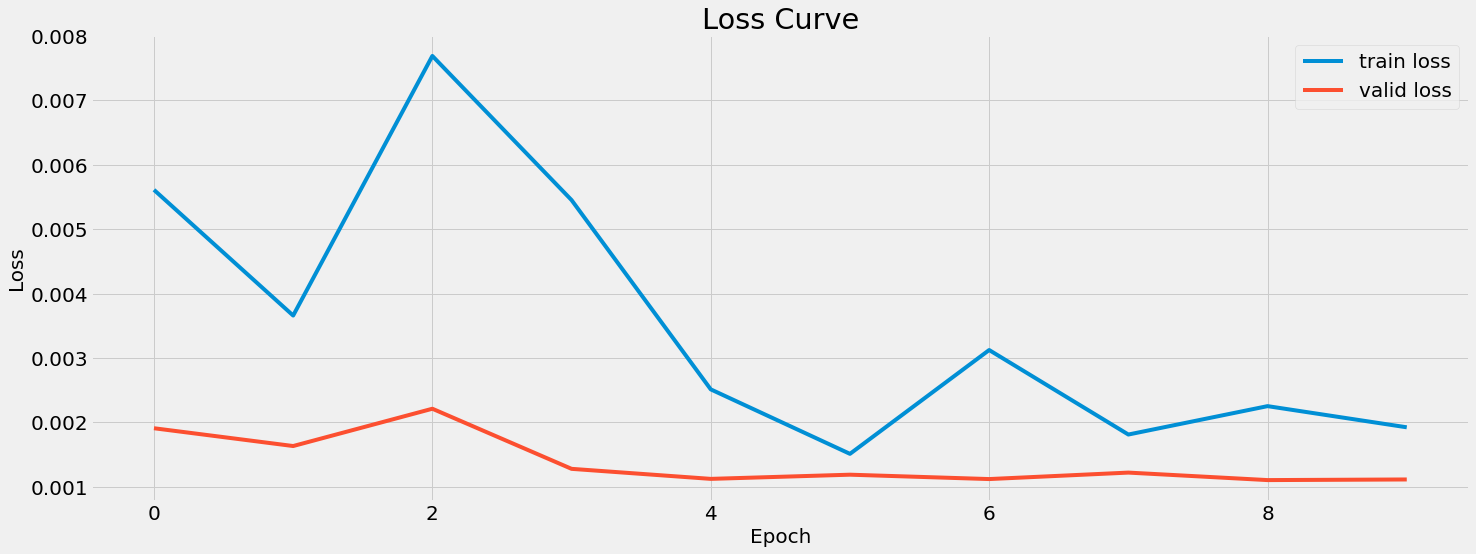

In [16]:
plt.style.use('fivethirtyeight')
plt.rcParams["font.size"] = "20"
fig = plt.figure(figsize=(22,8))
epochs = list(range(CFG.num_epochs))
plt.plot(epochs, history['train loss'], label='train loss')
plt.plot(epochs, history['valid loss'], label='valid loss')
plt.ylabel('Loss', fontsize=20)
plt.xlabel('Epoch', fontsize=20)
plt.legend()
plt.title('Loss Curve');

![Upvote!](https://img.shields.io/badge/Upvote-If%20you%20like%20my%20work-07b3c8?style=for-the-badge&logo=kaggle)